<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/Train%20fruit4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import PIL
import time
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import plotly.graph_objs as go
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## เตรียมชุดของข้อมูล

In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/0fruit')

In [4]:
batch_size = 15   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 150  # ความสูงของรูปภาพแต่ละรูป
img_width = 150   # ความกว้างของรูปภาพแต่ละรูป

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print("จำนวนรูปภาพทั้งหมด = ",image_count)

จำนวนรูปภาพทั้งหมด =  45


## Train

In [6]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.2, # s แบ่งข้อมูล เพื่อ training 80% และ validation 20%
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 45 files belonging to 3 classes.
Using 36 files for training.
Found 45 files belonging to 3 classes.
Using 9 files for validation.


In [7]:
class_names = train.class_names
print(class_names)

['apple', 'mangosteen', 'pineapple']


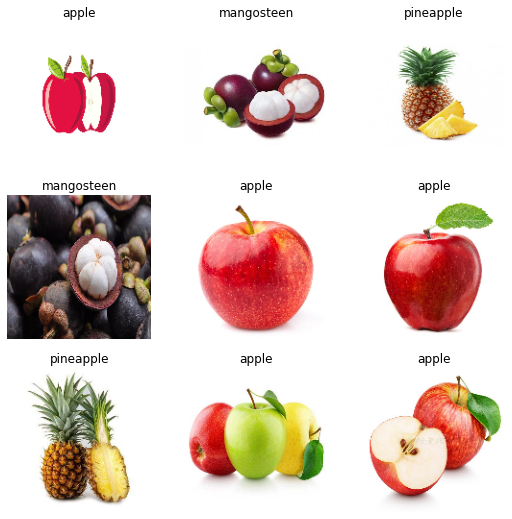

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9)) #ขนาด
for images, labels in train.take(1):
  for i in range(9): #มี 9 รูป
    ax = plt.subplot(3, 3, i + 1) #แถวละ 3
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(15, 150, 150, 3)
(15,)


## Normalization

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Model

In [11]:
num_classes = 3
epochs=20   # จำนวนครั้งที่เราจะ Train

In [12]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [14]:
his = model.fit(
train,
validation_data=val,
epochs=epochs
)

Epoch 1/20
3/3 [==============================] - 5s 2s/step - loss: 3.3984 - accuracy: 0.3333 - val_loss: 1.0501 - val_accuracy: 0.4444
Epoch 2/20
3/3 [==============================] - 2s 281ms/step - loss: 1.0943 - accuracy: 0.3889 - val_loss: 1.1255 - val_accuracy: 0.4444
Epoch 3/20
3/3 [==============================] - 2s 281ms/step - loss: 1.1579 - accuracy: 0.3056 - val_loss: 1.0701 - val_accuracy: 0.4444
Epoch 4/20
3/3 [==============================] - 2s 270ms/step - loss: 1.0918 - accuracy: 0.3056 - val_loss: 1.0316 - val_accuracy: 0.5556
Epoch 5/20
3/3 [==============================] - 2s 269ms/step - loss: 1.0426 - accuracy: 0.5556 - val_loss: 0.9610 - val_accuracy: 0.4444
Epoch 6/20
3/3 [==============================] - 2s 277ms/step - loss: 0.9674 - accuracy: 0.5000 - val_loss: 0.9118 - val_accuracy: 0.4444
Epoch 7/20
3/3 [==============================] - 2s 274ms/step - loss: 0.8592 - accuracy: 0.6389 - val_loss: 0.8087 - val_accuracy: 0.7778
Epoch 8/20
3/3 [=======

## Save Model

In [15]:
with open('history_model', 'wb') as file:
   p.dump(his.history, file)

filepath='model1.h5'
model.save(filepath)
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


## Load Model

In [16]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['loss'],
mode="lines", line=dict(
width=2,
color='blue'),
name="loss"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testMNIST")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

## Prediction

1/1 [==============================] - 0s 117ms/step
apple tf.Tensor(0.9926966, shape=(), dtype=float32) mangosteen tf.Tensor(0.0008938947, shape=(), dtype=float32) pineapple tf.Tensor(0.0064094528, shape=(), dtype=float32)


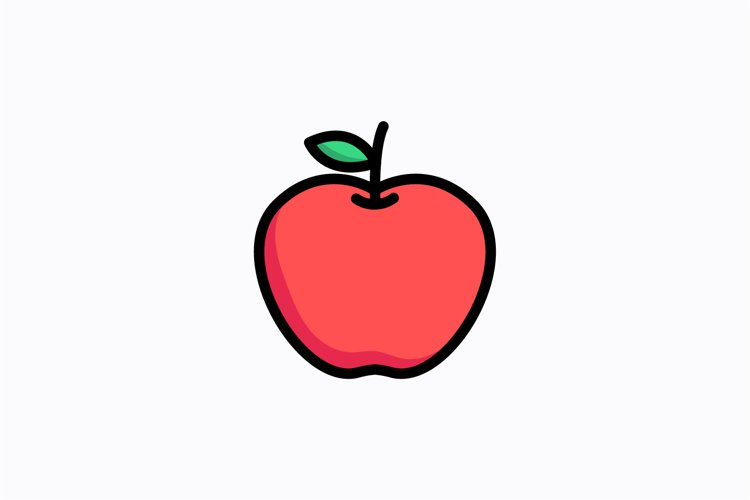

AI apple มีความมั่นใจ 99.27%.


In [17]:
import requests
from IPython.display import Image
from io import BytesIO
test_path = ('/content/drive/My Drive/a1.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 33ms/step
apple tf.Tensor(0.99932015, shape=(), dtype=float32) mangosteen tf.Tensor(2.773112e-05, shape=(), dtype=float32) pineapple tf.Tensor(0.0006520821, shape=(), dtype=float32)


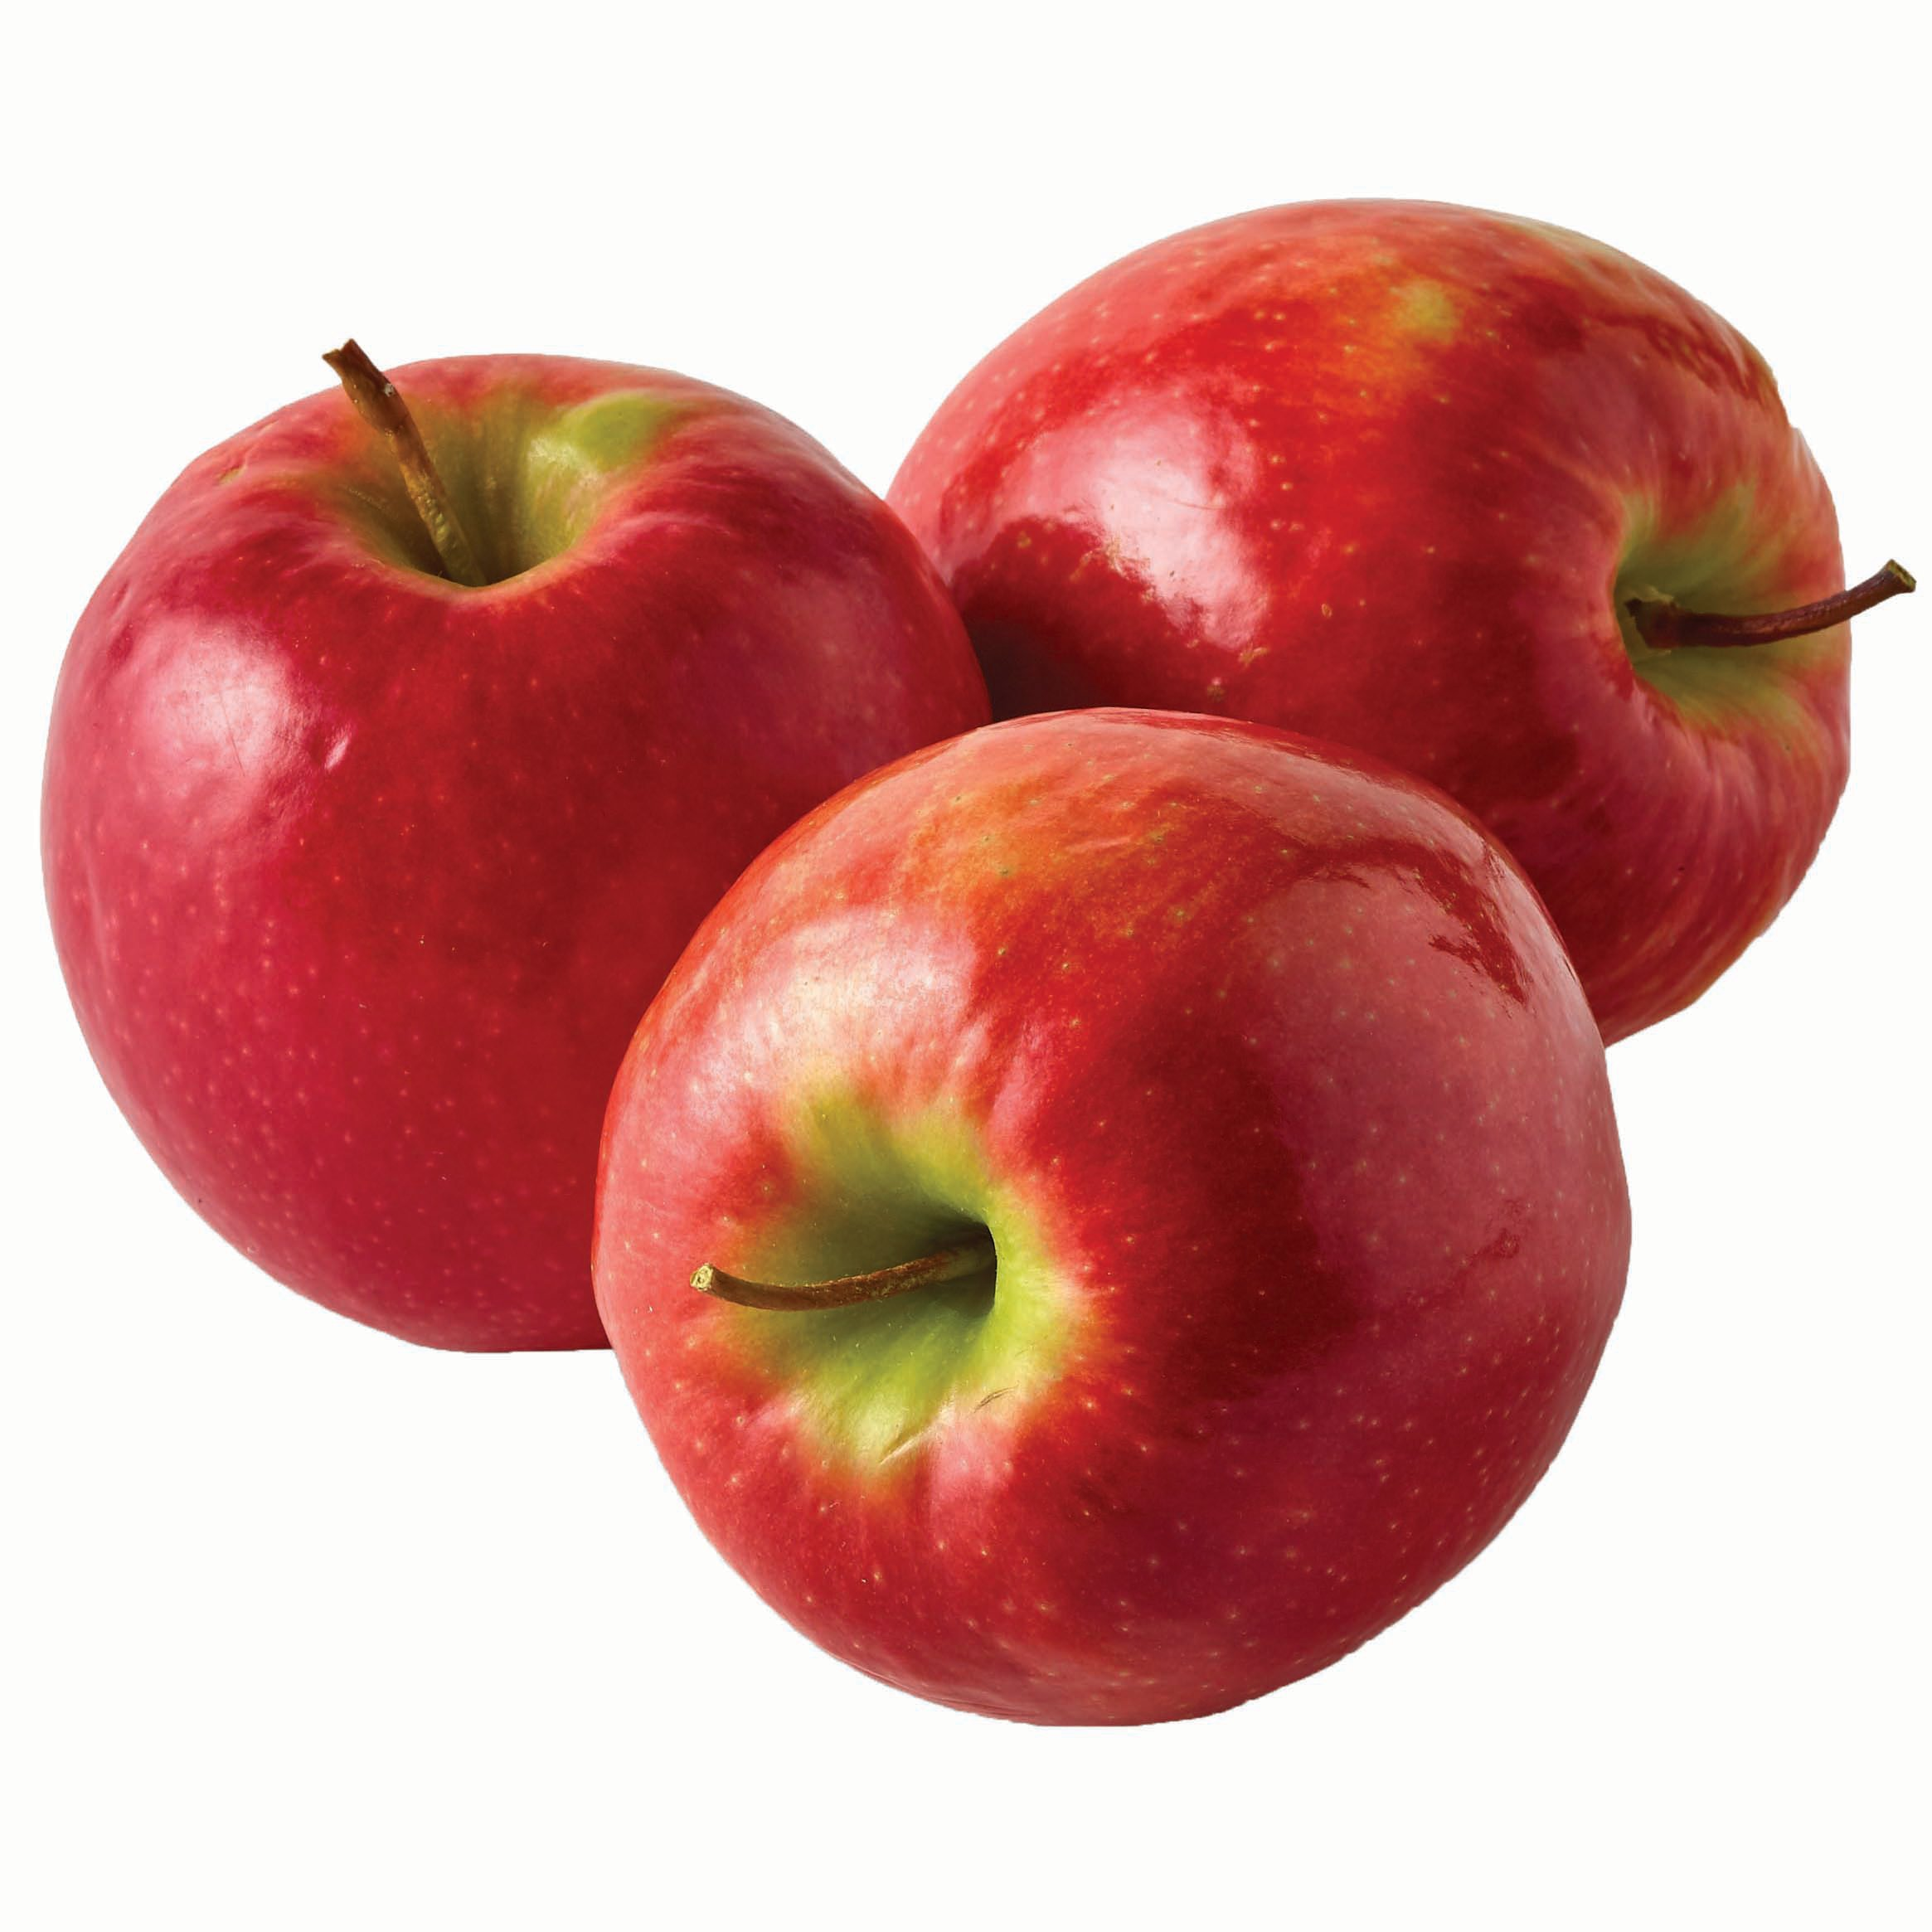

AI apple มีความมั่นใจ 99.93%.


In [18]:
test_path = ('/content/drive/My Drive/0/ap.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 27ms/step
apple tf.Tensor(0.0027760966, shape=(), dtype=float32) mangosteen tf.Tensor(0.99664366, shape=(), dtype=float32) pineapple tf.Tensor(0.00058029324, shape=(), dtype=float32)


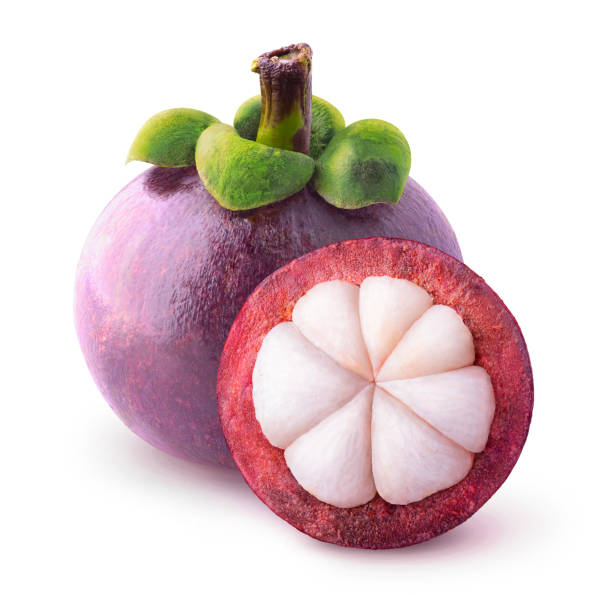

AI mangosteen มีความมั่นใจ 99.66%.


In [19]:
test_path = ('/content/drive/My Drive/0/ma.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
apple tf.Tensor(1.0944883e-06, shape=(), dtype=float32) mangosteen tf.Tensor(2.69052e-13, shape=(), dtype=float32) pineapple tf.Tensor(0.9999989, shape=(), dtype=float32)


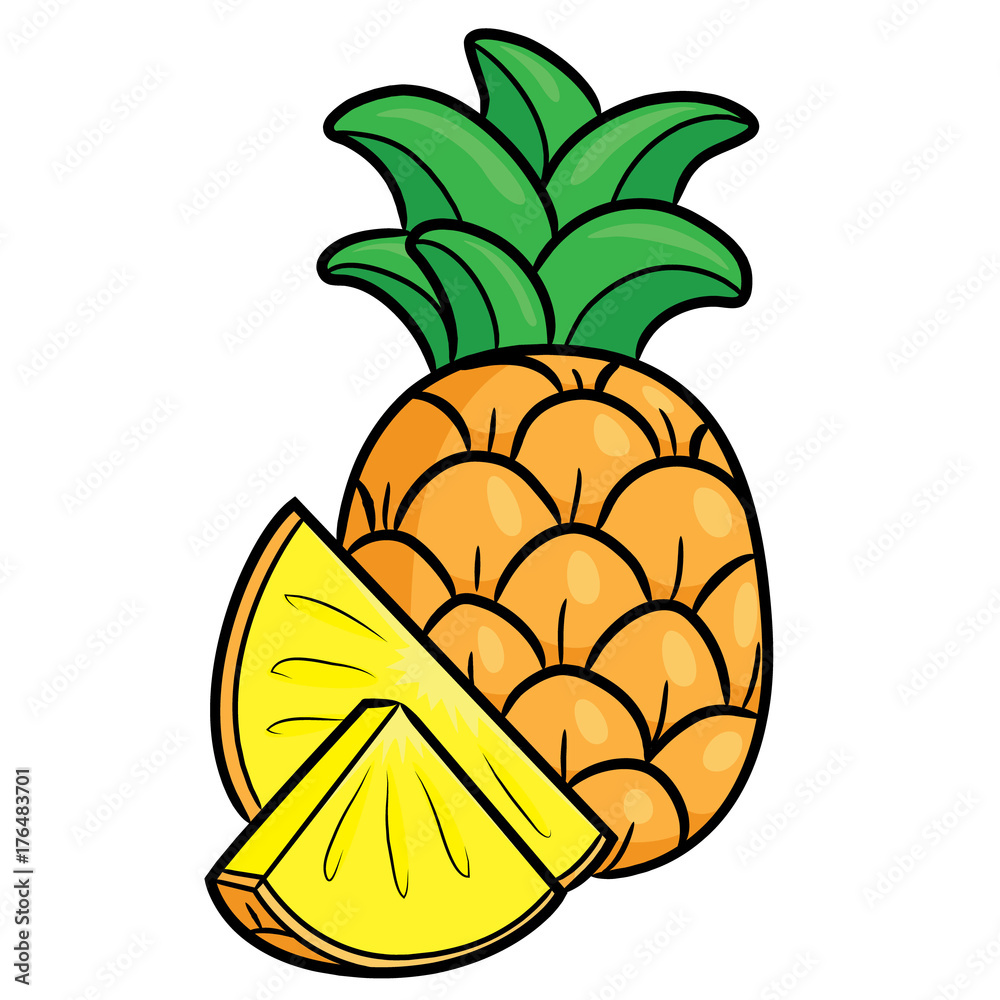

AI pineapple มีความมั่นใจ 100.00%.


In [20]:
test_path = ('/content/drive/My Drive/0/pi.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

# Test

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

In [23]:
# dimensions of our images
img_width, img_height = 150, 150

# Load the model we save
model = load_model('model1.h5')

['a2.png', 'a1.png', 'm1.png', 'm3.png', 'm2.png', 'a3.png', 'p1.png', 'p2.png', 'p3.png']
a2.png


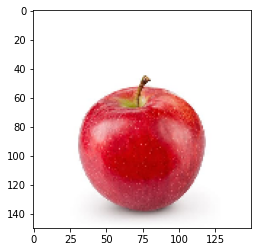

1/1 [==============================] - 0s 41ms/step
[[-0.6514409   0.07016985  0.5435943 ]]
pineapple , 54.36
a2.png: pineapple
--------------------------------------------
a1.png


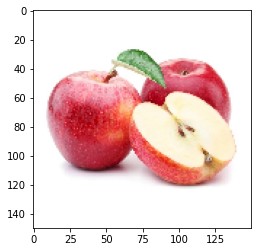

1/1 [==============================] - 0s 38ms/step
[[-0.6513348   0.06952485  0.5425301 ]]
pineapple , 54.25
a1.png: pineapple
--------------------------------------------
m1.png


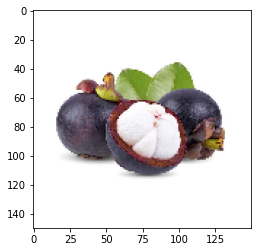

1/1 [==============================] - 0s 50ms/step
[[-0.6578587   0.07857002  0.5378502 ]]
pineapple , 53.79
m1.png: pineapple
--------------------------------------------
m3.png


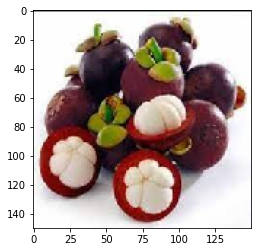

1/1 [==============================] - 0s 32ms/step
[[-0.64977974  0.06182933  0.5492931 ]]
pineapple , 54.93
m3.png: pineapple
--------------------------------------------
m2.png


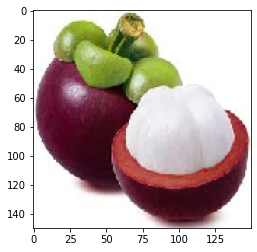

1/1 [==============================] - 0s 28ms/step
[[-0.6511793   0.06662876  0.544926  ]]
pineapple , 54.49
m2.png: pineapple
--------------------------------------------
a3.png


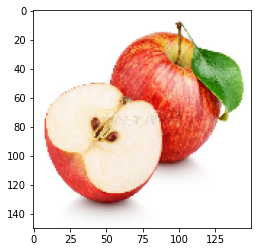

1/1 [==============================] - 0s 32ms/step
[[-0.64675784  0.06409734  0.543698  ]]
pineapple , 54.37
a3.png: pineapple
--------------------------------------------
p1.png


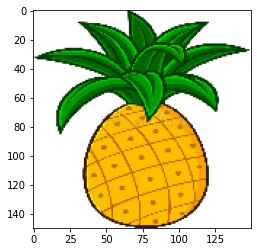

1/1 [==============================] - 0s 32ms/step
[[-0.6441049   0.02996859  0.5836577 ]]
pineapple , 58.37
p1.png: pineapple
--------------------------------------------
p2.png


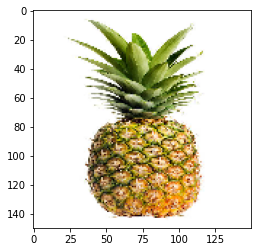

1/1 [==============================] - 0s 37ms/step
[[-0.6540916   0.05039174  0.57052433]]
pineapple , 57.05
p2.png: pineapple
--------------------------------------------
p3.png


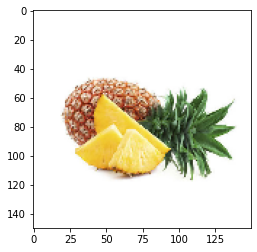

1/1 [==============================] - 0s 30ms/step
[[-0.655733    0.06466851  0.5543682 ]]
pineapple , 55.44
p3.png: pineapple
--------------------------------------------


In [34]:
mypath = ('/content/drive/My Drive/0testfruit/')
# Label_calss = {'apple','mangosteen','pineapple'}
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

# Predicting images
for file in onlyfiles:
  print(file)
  img = image.load_img(mypath+file, target_size=(img_width, img_height))

  imgplot = plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x /= 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  # classes = model.predict_classes(images)
  print(classes)
  #classes = classes[0][0]

  if np.argmax(classes) == 0:
    print("%s , %.2f" % ("apple", (classes[0][np.argmax(classes)]*100)))
    print(file + ": " + 'apple')
  
  elif np.argmax(classes) == 1:
    print("%s , %.2f" % ("mangosteen", (classes[0][np.argmax(classes)]*100)))
    print(file + ": " + 'mangosteen')
  
  else :
    print("%s , %.2f" % ("pineapple", (classes[0][np.argmax(classes)]*100)))
    print(file + ": " + 'pineapple')
  

  print('--------------------------------------------')

# Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix as cm

In [39]:
cm=confusion_matrix(y_test, y_pred,labels=[0,1])
print("Confusion Matrix:")
print(cm)

NameError: ignored

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,cmap="Reds",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ValueError: ignored

In [43]:
# normalized
print("Normalized Confusion Matrix:")
cm_normalized=np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
print(cm_normalized)
sns.heatmap(cm,cmap="Greens",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

Normalized Confusion Matrix:


AxisError: ignored

In [44]:
# heatmap

sns.heatmap(cm,cmap="Greens",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ValueError: ignored